# **Agentic AI for Image Classification** - Create three agents: CNN-CIFAR, which classifies CIFAR-10 images upon request; RESNET-CIFAR, which also classifies CIFAR-10 images upon request; and a Judge agent, which compares the performance of the two by sending images to each via messages and requesting classifications.

# Step 1: Setup Required Packages

In [2]:
# MH - This is based on W03_5_Publish_Subscribe.ipynb
# There is more code where then needed, just need time to test a cleaned up version
# Step 1: Install all required packages

!pip install tensorflow keras numpy matplotlib
!pip install kafka-python

# Download Kafka binaries
!curl -sSOL https://archive.apache.org/dist/kafka/3.5.0/kafka_2.13-3.5.0.tgz
!tar -xzf kafka_2.13-3.5.0.tgz

# Start Zookeeper (Kafka needs this to manage the cluster)
!./kafka_2.13-3.5.0/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.5.0/config/zookeeper.properties

# Start Kafka Broker
!./kafka_2.13-3.5.0/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.5.0/config/server.properties

# Give it a few seconds to boot up
import time
time.sleep(10)
print("Kafka Broker is now running!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.3/326.3 kB 15.2 MB/s eta 0:00:00
Kafka Broker is now running!


# Step 2: Load CIFAR-10 Data and setup functions

Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Training images: (50000, 32, 32, 3)
Test images: (10000, 32, 32, 3)


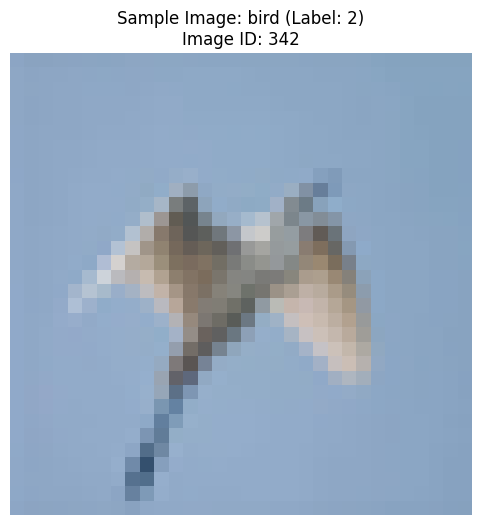

CIFAR-10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
# MH - This was recreated from W04_CNN.ipynb and I had AI help me rebuild it to be more dynamic with functions and variables I'll be reusing.
# Step 2: Load CIFAR-10 and create helper functions

import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10

from PIL import Image
import csv

# CIFAR-10 class names
CIFAR10_CLASSES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Topics for message broker
REQUEST_TOPIC = 'cifar_classification_requests'
CNN_RESPONSE_TOPIC = 'cnn_classifications'
RESNET_RESPONSE_TOPIC = 'resnet_classifications'

# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # MH - This is splitting the data.  AI is telling me that the split based on the output.

# Normalize pixel values (0-255 -> 0-1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten labels
y_train = y_train.flatten()
y_test = y_test.flatten()

print(f"Training images: {x_train.shape}")
print(f"Test images: {x_test.shape}")


# MH - I just wanted to see a random image
def get_random_test_image():
    """Show a random image and it's label"""
    idx = np.random.randint(0, len(x_test))
    return {
        'image_id': idx,
        'image_data': x_test[idx].tolist(),  #
        'true_label': int(y_test[idx]),
        'true_class': CIFAR10_CLASSES[y_test[idx]]
    }


def decode_prediction(predictions):
    """Convert model output to class name and confidence"""
    predicted_class = np.argmax(predictions)
    confidence = float(predictions[predicted_class])
    return {
        'predicted_class': int(predicted_class),
        'predicted_name': CIFAR10_CLASSES[predicted_class],
        'confidence': confidence
    }

def numpy_to_json(arr):
    """Convert numpy array to JSON-serializable format"""
    return json.dumps(arr.tolist())

def json_to_numpy(json_str):
    """Convert JSON string back to numpy array"""
    return np.array(json.loads(json_str))

# MH - Display a sample image to show that it is working
import matplotlib.pyplot as plt

sample = get_random_test_image()
plt.figure(figsize=(6, 6))
plt.imshow(np.array(sample['image_data']))
plt.title(f"Sample Image: {sample['true_class']} (Label: {sample['true_label']})\nImage ID: {sample['image_id']}")
plt.axis('off')
plt.show()
print(f"CIFAR-10 classes: {CIFAR10_CLASSES}")

# Step 3: Build & train the CNN Model

In [4]:
# MH - This is based on previous assignement with AI helping to making it code I can call
# Step 3: Build and train the CNN model
from tensorflow.keras import layers, models

def build_cnn_model():
    model = models.Sequential([
      # BLOCK 1: INITIALIZE
      layers.RandomFlip("horizontal", input_shape=(32, 32, 3)), # MH - AI suggested this flip so the focus is on learning the pattern, not the data
      layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.Conv2D(32, (3, 3), activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Dropout(0.2),

      # BLOCK 2: SECONDARY FEATURE MAPPING
      layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Dropout(0.3),

      # BLOCK 3: CLASSIFIER HEAD
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


print("Building CNN model...")
cnn_model = build_cnn_model()
cnn_model.summary()


# MH - Added these to improve performance
from tensorflow.keras.callbacks import EarlyStopping

# This stops training if val_loss doesn't improve for 3 straight epochs
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_cnn = cnn_model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop]
)


# Evaluate on test set
test_loss, test_acc = cnn_model.evaluate(x_test[:1000], y_test[:1000], verbose=0)
print(f"CNN Test Accuracy: {test_acc*100:.2f}%")

Building CNN model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 432,490 (1.65 MB)

 Trainable params: 431,978 (1.65 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.3619 - loss: 2.0203 - val_accuracy: 0.5260 - val_loss: 1.3175
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5679 - loss: 1.2260 - val_accuracy: 0.6607 - val_loss: 0.9624
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6307 - loss: 1.0527 - val_accuracy: 0.6719 - val_loss: 0.9124
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6703 - loss: 0.9461 - val_accuracy: 0.6865 - val_loss: 0.8846
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6871 - loss: 0.8975 - val_accuracy: 0.6786 - val_loss: 0.9078
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6997 - loss: 0.8610 - val_accuracy: 0.7009 - val_loss: 0.8492
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7175 - loss: 0.8105 - val_accuracy: 0.7160 - val_loss: 0.8098
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7232 - loss: 0.7870 - val_accuracy: 0

# Step 4: Build & train the ResNet Model

In [5]:
# MH - Wasn't sure how to build the code for this so I leveraged AI.  I had AI give me lots of notes.
# Step 4: Build and train a ResNet model
from tensorflow.keras import layers, models

def build_resnet_model():
    inputs = layers.Input(shape=(32, 32, 3))

    x = layers.RandomFlip("horizontal")(inputs) # MH - AI suggested this flip so the focus is on learning the pattern, not the data

    # Initial Convolutional Layer
    x = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # REUSABLE RESIDUAL BLOCK FUNCTION
    def residual_block(x, filters, downsample=False):
        shortcut = x
        stride = (2, 2) if downsample else (1, 1)

        # SHORTCUT - Adjust shortcut if dimensions change
        if downsample or x.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        # BLOCK - First Conv
        x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        # BLOCK - Second Conv
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)

        # ADDITION AND THEN ACTIVATION
        x = layers.Dropout(0.2)(x)
        x = layers.add([x, shortcut])
        x = layers.Activation('relu')(x)
        return x

    # Model Backbone
    x = residual_block(x, 64)
    x = residual_block(x, 128, downsample=True) # Downsamples to 16x16
    x = residual_block(x, 256, downsample=True) # Downsamples to 8x8

    # Modern Classifier Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build the ResNet model
print("Building ResNet model...")
resnet_model = build_resnet_model()
resnet_model.summary()


# MH - Added these to improve performance
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# This stops training if val_loss doesn't improve for 3 straight epochs
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# It's like telling the model: "Slow down and pay attention to the details."
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)


history_resnet = resnet_model.fit(
    x_train, y_train,
    epochs=50, # Set it high
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, lr_callback]
)


# Evaluate on test set
test_loss, test_acc = resnet_model.evaluate(x_test[:1000], y_test[:1000], verbose=0)
print(f"ResNet Test Accuracy: {test_acc*100:.2f}%")

Building ResNet model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ dropout_3[0][0],  │
│                     │ 64)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │     73,856 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │    147,584 │ activation_3[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_8[0][0]  

 Total params: 1,263,242 (4.82 MB)

 Trainable params: 1,260,554 (4.81 MB)

 Non-trainable params: 2,688 (10.50 KB)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.3344 - loss: 1.7985 - val_accuracy: 0.2814 - val_loss: 3.7312 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.5393 - loss: 1.2735 - val_accuracy: 0.5902 - val_loss: 1.1242 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.6203 - loss: 1.0703 - val_accuracy: 0.5694 - val_loss: 1.2559 - learning_rate: 0.0010
Epoch 4/50
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6543 - loss: 0.9747
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.6543 - loss: 0.9746 - val_accuracy: 0.5757 - val_loss: 1.3014 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.7163 - loss: 0.8084 - val_accuracy: 0.7179 - val_loss: 0.8013 - learning_rate: 5.0000e-04
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.7424 -

In [6]:
# MH - Saving trained models

#from google.colab import drive
#drive.mount('/content/drive')

#cnn_model.save('/content/drive/MyDrive/cnn_cifar_model.keras')
#print("CNN Model saved successfully to Google Drive!")

#resnet_model.save('/content/drive/MyDrive/resnet_cifar_model.keras')
#print("ResNet Model saved successfully to Google Drive!")

# Step 5: Build the CNN Agent (Publisher/Subscriber)

In [7]:
# MH - The is based on the previous broker homework, used AI to help me keep it active.
# Step 5: CNN Agent - Listens for requests and classifies images

import json
import time
from kafka import KafkaConsumer, KafkaProducer
import numpy as np
import logging

logging.getLogger('kafka').setLevel(logging.CRITICAL) # MH - Stops the noise

def run_cnn_agent(max_messages=100):
    # Consumer: Listen for requests
    consumer = KafkaConsumer(
        REQUEST_TOPIC,
        bootstrap_servers=['localhost:9092'],
        group_id='cnn_classifier_group',
        auto_offset_reset='latest',
        value_deserializer=lambda x: json.loads(x.decode('utf-8')),
        consumer_timeout_ms=60000  # Wait 60 seconds for messages
    )

    # Producer: Send classification results
    producer = KafkaProducer(
        bootstrap_servers=['localhost:9092'],
        value_serializer=lambda v: json.dumps(v).encode('utf-8')
    )

    print("CNN-CIFAR AGENT is ready and listening for requests")

    message_count = 0
    for message in consumer:
        request = message.value
        image_id = request['image_id']

        # Reconstruct the image from the request
        image_data = np.array(request['image_data'])
        image_batch = np.expand_dims(image_data, axis=0)

        # Classify using CNN model
        start_time = time.time()
        predictions = cnn_model.predict(image_batch, verbose=0)[0]
        inference_time = time.time() - start_time

        # Decode prediction
        result = decode_prediction(predictions)

        response = {
            'agent': 'CNN-CIFAR',
            'image_id': image_id,
            'true_label': request['true_label'],
            'true_class': request['true_class'],
            'predicted_class': result['predicted_class'],
            'predicted_name': result['predicted_name'],
            'confidence': result['confidence'],
            'inference_time_ms': inference_time * 1000,
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
        }

        producer.send(CNN_RESPONSE_TOPIC, value=response)

        message_count += 1
        if message_count >= max_messages:
            break

    producer.flush()
    consumer.close()

print("CNN Agent function created and ready!")

import threading
threading.Thread(target=run_cnn_agent, daemon=True).start()
print("CNN Agent is now running in the background...")
time.sleep(2)

CNN Agent function created and ready!
CNN Agent is now running in the background...
CNN-CIFAR AGENT is ready and listening for requests


# Step 6: Build the ResNet Agent

In [8]:
# MH - The is based on the previous broker homework, used AI to help me keep it active.
# Step 6: ResNet Agent - Listens for requests and classifies images

logging.getLogger('kafka').setLevel(logging.CRITICAL) # MH - Keeping the noise down

def run_resnet_agent(max_messages=100):

    # Consumer: Listen for classification requests
    consumer = KafkaConsumer(
        REQUEST_TOPIC,
        bootstrap_servers=['localhost:9092'],
        group_id='resnet_classifier_group',
        auto_offset_reset='latest',
        value_deserializer=lambda x: json.loads(x.decode('utf-8')),
        consumer_timeout_ms=60000 # Wait 60 seconds for messages
    )

    # Producer: Send classification results
    producer = KafkaProducer(
        bootstrap_servers=['localhost:9092'],
        value_serializer=lambda v: json.dumps(v).encode('utf-8')
    )

    print("RESNET-CIFAR AGENT is ready and listening for requests...")

    message_count = 0
    for message in consumer:
        request = message.value
        image_id = request['image_id']

        # Reconstruct the image from the request
        image_data = np.array(request['image_data'])
        image_batch = np.expand_dims(image_data, axis=0)

        # Classify using ResNet model
        start_time = time.time()
        predictions = resnet_model.predict(image_batch, verbose=0)[0]
        inference_time = time.time() - start_time

        # Decode prediction
        result = decode_prediction(predictions)

        # Prepare response message
        response = {
            'agent': 'RESNET-CIFAR',
            'image_id': image_id,
            'true_label': request['true_label'],
            'true_class': request['true_class'],
            'predicted_class': result['predicted_class'],
            'predicted_name': result['predicted_name'],
            'confidence': result['confidence'],
            'inference_time_ms': inference_time * 1000,
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
        }

        # Publish response
        producer.send(RESNET_RESPONSE_TOPIC, value=response)

        message_count += 1
        if message_count >= max_messages:
            break

    producer.flush()
    consumer.close()


print("ResNet Agent function created and ready!")

import threading
threading.Thread(target=run_resnet_agent, daemon=True).start()
print("ResNet Agent is now running in the background...")
time.sleep(2)

ResNet Agent function created and ready!
ResNet Agent is now running in the background...
RESNET-CIFAR AGENT is ready and listening for requests...


# Step 7: Build the Judge Agent

In [9]:
# MH - The is based on the previous broker homework, used AI to help me keep it active.
# Step 7: Judge Agent - Sends requests and compares performance

import json
import time
from kafka import KafkaProducer, KafkaConsumer
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

def run_judge_agent(num_images=500):
    # Producer and Consumer Setup
    request_producer = KafkaProducer(
        bootstrap_servers=['localhost:9092'],
        value_serializer=lambda v: json.dumps(v).encode('utf-8')
    )

    cnn_consumer = KafkaConsumer(
        CNN_RESPONSE_TOPIC,
        bootstrap_servers=['localhost:9092'],
        group_id=f'judge_cnn_{int(time.time())}',
        auto_offset_reset='earliest',
        value_deserializer=lambda x: json.loads(x.decode('utf-8')),
        consumer_timeout_ms=10000
    )

    resnet_consumer = KafkaConsumer(
        RESNET_RESPONSE_TOPIC,
        bootstrap_servers=['localhost:9092'],
        group_id=f'judge_resnet_{int(time.time())}',
        auto_offset_reset='earliest',
        value_deserializer=lambda x: json.loads(x.decode('utf-8')),
        consumer_timeout_ms=10000
    )

    print(f"JUDGE AGENT: Submitting {num_images} images to Broker...")

    # Publish requests
    for _ in tqdm(range(num_images), desc="Publishing"):
        image_request = get_random_test_image()
        request_producer.send(REQUEST_TOPIC, value=image_request)
        time.sleep(0.01)

    request_producer.flush()

    # Collect results
    cnn_results = []
    with tqdm(total=num_images, desc="CNN Processing", leave=False) as pbar:
        for message in cnn_consumer:
            cnn_results.append(message.value)
            pbar.update(1)
            if len(cnn_results) >= num_images: break

    resnet_results = []
    with tqdm(total=num_images, desc="ResNet Processing", leave=False) as pbar:
        for message in resnet_consumer:
            resnet_results.append(message.value)
            pbar.update(1)
            if len(resnet_results) >= num_images: break

    # Cleanup
    cnn_consumer.close()
    resnet_consumer.close()
    request_producer.close()

    # Analyze results
    comparison_map = defaultdict(dict)

    for r in cnn_results:
        comparison_map[r['image_id']]['cnn'] = r

    for r in resnet_results:
        comparison_map[r['image_id']]['resnet'] = r

    # Variables to track performance
    cnn_total_correct = 0
    resnet_total_correct = 0
    brokered_total_correct = 0
    images_with_both_responses = 0

    for img_id, results in comparison_map.items():
        if 'cnn' in results and 'resnet' in results:
            images_with_both_responses += 1

            cnn_res = results['cnn']
            res_res = results['resnet']

            # Check individual accuracy
            if cnn_res['predicted_class'] == cnn_res['true_label']:
                cnn_total_correct += 1
            if res_res['predicted_class'] == res_res['true_label']:
                resnet_total_correct += 1

            # Pick the highest confidence
            if cnn_res['confidence'] >= res_res['confidence']:
                choice = cnn_res
            else:
                choice = res_res

            if choice['predicted_class'] == choice['true_label']:
                brokered_total_correct += 1

    # RETURN
    return {
        'total': images_with_both_responses,
        'cnn_correct': cnn_total_correct,
        'resnet_correct': resnet_total_correct,
        'brokered_correct': brokered_total_correct
    }

print("Judge Agent function ready")
time.sleep(2)

Judge Agent function ready


# Step 8: Run All Agents with Threading

In [10]:
# MH - AI helped me put this together so they would all run at the same time
# Step 8: Orchestration

import threading

def run_complete_system(num_test_images=500): # Changed default to 500
    final_output = []

    def judge_wrapper():
        # Call the judge and save its return value to the list
        res = run_judge_agent(num_images=num_test_images)
        final_output.append(res)

    cnn_thread = threading.Thread(
        target=run_cnn_agent,
        args=(num_test_images,),
        daemon=True
    )
    resnet_thread = threading.Thread(
        target=run_resnet_agent,
        args=(num_test_images,),
        daemon=True
    )

    judge_thread = threading.Thread(target=judge_wrapper)

    # Start and wait
    cnn_thread.start()
    resnet_thread.start()
    time.sleep(2)

    judge_thread.start()
    judge_thread.join()
    time.sleep(2)

    # Return the first item in our results list
    return final_output[0] if final_output else None

print("System orchestration function ready!")

System orchestration function ready!


# Step 9: Restart Kafka

In [11]:
# MH - I found that I needed to restart Kafka because it would stop after the model training.  I didn't know the syntac for this so leveraged AI.
# Since adding this I learned of the Runtime T4 GPU setting so I'm not sure if it is still needed but I ran out of time to test without it.
# Step 9: Restart Kafka

import os
import subprocess
import time

# Kill any existing "zombie" processes
print("Cleaning up existing Kafka 3.5.0 processes...")
!ps ax | grep -i 'kafka\|zookeeper' | grep -v grep | awk '{print $1}' | xargs -r kill -9
!rm -rf /tmp/kafka-logs /tmp/zookeeper

# Verify the folder exists (3.5.0)
if not os.path.exists('kafka_2.13-3.5.0'):
    print("Kafka 3.5.0 missing. Re-downloading...")
    !curl -sSOL https://archive.apache.org/dist/kafka/3.5.0/kafka_2.13-3.5.0.tgz
    !tar -xzf kafka_2.13-3.5.0.tgz

# Start Zookeeper (No daemon, so we can see errors in the log file)
print("Starting Zookeeper...")
with open('zookeeper.log', 'w') as f:
    subprocess.Popen(['./kafka_2.13-3.5.0/bin/zookeeper-server-start.sh', './kafka_2.13-3.5.0/config/zookeeper.properties'], stdout=f, stderr=f)
time.sleep(7)

#Start Kafka Broker
print("Starting Kafka Broker...")
with open('kafka.log', 'w') as f:
    subprocess.Popen(['./kafka_2.13-3.5.0/bin/kafka-server-start.sh', './kafka_2.13-3.5.0/config/server.properties'], stdout=f, stderr=f)

# Wait and Verify
print("Waiting 15 seconds for stability...")
time.sleep(15)


print("Checking topics...")
!./kafka_2.13-3.5.0/bin/kafka-topics.sh --bootstrap-server localhost:9092 --list
print("KAFKA 3.5.0 IS READY!")

Cleaning up existing Kafka 3.5.0 processes...
Starting Zookeeper...
Starting Kafka Broker...
Waiting 15 seconds for stability...
Checking topics...
__consumer_offsets
cifar_classification_requests
KAFKA 3.5.0 IS READY!


# Step 10: Execute the System & Visualize Performance

Executing Broker Test: Processing 500 images...
RESNET-CIFAR AGENT is ready and listening for requests...
CNN-CIFAR AGENT is ready and listening for requests
JUDGE AGENT: Submitting 500 images to Broker...


Publishing:   0%|          | 0/500 [00:00<?, ?it/s]

CNN Processing:   0%|          | 0/500 [00:00<?, ?it/s]

ResNet Processing:   0%|          | 0/500 [00:00<?, ?it/s]

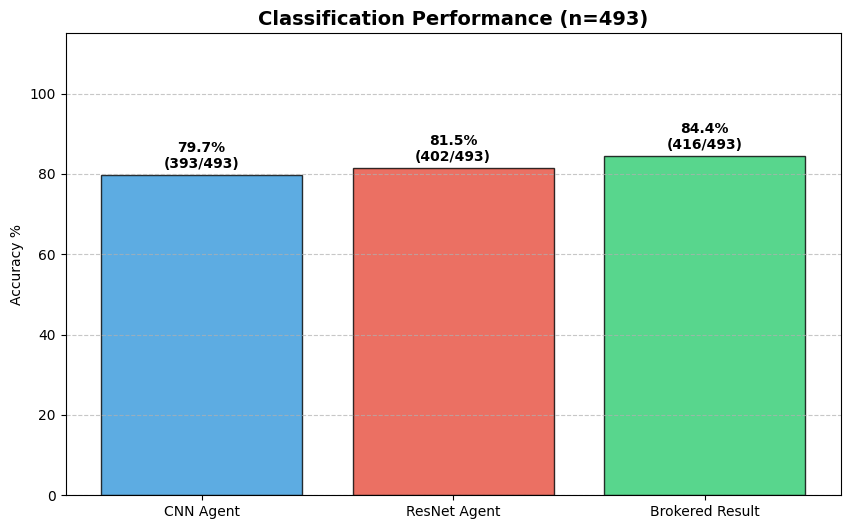

In [12]:
# MH - Run everything and give a visual.  Again this was new for me so I leverage AI for syntax and did some cleanup.
# Step 10: Full Scale Test and Visualization

import matplotlib.pyplot as plt
import logging

# Silence Kafka logs to keep output clean
logging.getLogger('kafka').setLevel(logging.ERROR)

if __name__ == "__main__":
    TOTAL_IMAGES = 500
    print(f"Executing Broker Test: Processing {TOTAL_IMAGES} images...")
    stats = run_complete_system(num_test_images=TOTAL_IMAGES)

    if stats:
        actual_total = stats.get('total', TOTAL_IMAGES)

        labels = ['CNN Agent', 'ResNet Agent', 'Brokered Result']
        counts = [stats['cnn_correct'], stats['resnet_correct'], stats['brokered_correct']]
        accuracies = [(c / actual_total) * 100 for c in counts]

        plt.figure(figsize=(10, 6))
        colors = ['#3498db', '#e74c3c', '#2ecc71']
        bars = plt.bar(labels, accuracies, color=colors, edgecolor='black', alpha=0.8)

        for bar, count in zip(bars, counts):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                     f'{height:.1f}%\n({count}/{actual_total})',
                     ha='center', va='bottom', fontweight='bold')

        plt.title(f'Classification Performance (n={actual_total})', fontsize=14, fontweight='bold')
        plt.ylabel('Accuracy %')
        plt.ylim(0, 115)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()